<a href="https://colab.research.google.com/github/rajattiwari010/All_Chest_Disease_Prediction/blob/MY-REPO's/Chest_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chest X-Ray Medical Diagnosis with Deep Learning**

---



In [ ]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing necessary packages

import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]


#Data Exploration

#reading csv  file containing training data, testing data, validating data

train_df=pd.read_csv("/content/drive/MyDrive/DATABASE/miccai2023_nih-cxr-lt_labels_train.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/DATABASE/miccai2023_nih-cxr-lt_labels_val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DATABASE/miccai2023_nih-cxr-lt_labels_test.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.rename(columns={'id': 'Image'}, inplace=True)
test_df.rename(columns={'id': 'Image'}, inplace=True)
valid_df.rename(columns={'id': 'Image'}, inplace=True)


There are 78506 rows and 22 columns in the train data frame


In [ ]:
print(f"Train set: The total patient ids are {train_df['Image'].count()}, from those the unique ids are {train_df['Image'].value_counts().shape[0]} ")
print(f"Validation set: The total patient ids are {valid_df['Image'].count()}")
print(f"Test set: The total patient ids are {test_df['Image'].count()}")

Train set: The total patient ids are 78506, from those the unique ids are 78506 
Validation set: The total patient ids are 12533
Test set: The total patient ids are 21081


Explore data labels

In [ ]:
#creating list of names of each details
columns = train_df.keys()
columns = list(columns)
print(columns)


# # Remove unnecesary elements
# columns.remove('subj_id')
# columns.remove('id')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")
# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding', 'subj_id']
There are 22 columns of labels for these conditions: ['Image', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding', 'subj_id']
The class Image has 00000001_000.png00000001_001.png00000001_002.png00000002_000.png00000004_000.png00000005_000.png00000005_001.png00000005_002.png00000005_003.png00000005_004.png00000005_005.png00000005_006.png00000005_007.png00000006_000.png00000007_000.png00000008_

Data Visualization

In [ ]:
# # Extract numpy values from id column in data frame
# images = train_df['Image'].values

# # Extract 9 random images from it
# random_images = [np.random.choice(images) for i in range(9)]

# # Location of the image dir
# img_dir = '/content/drive/MyDrive/DATABASE/images'

# print('Display Random Images')

# # Adjust the size of your images
# plt.figure(figsize=(20,10))

# # Iterate and plot random images
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     img = plt.imread(os.path.join(img_dir, random_images[i]))
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')

# # Adjust subplot parameters to give specified padding
# plt.tight_layout()

Image Preprocessing in Keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
  print("getting train generator...")
    # Normalize images  --- Generate batches of tensor image data with real-time data augmentation
  image_generator = ImageDataGenerator(
        samplewise_center=True,              #Set each sample mean to 0
        samplewise_std_normalization= True)  # Divide each input by its standard deviation

    # flow from directory with specified batch size and target image size
    # flow_from_dataframe ==> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
    # RETURNS a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with
    # shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels
    # default data format of ImageGenerator is channels_last
  generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",       #  Mode for yielding the targets, one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical".
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

  return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8,
                                 seed=1, target_w = 320, target_h = 320):
  # get generator to sample dataset
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    # get data sample
    batch = raw_train_generator.next() # generate a batch of samples and associated labels
    data_sample = batch[0]             # => we need only the sample imgs ie batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    # fit generator to sample from training data - we use this generator normalizing mean and std using the train sample of 100
    image_generator.fit(data_sample)

    print("\ngetting valid generator...")
     # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "/content/drive/MyDrive/DATABASE/images"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1326 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 77180 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(



extracting 100 train images to normalize validation and test datasets...
Found 1326 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 77180 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(



getting valid generator...
Found 256 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 12277 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(



getting test generator...
Found 428 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 20653 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.03996983, 0.02790347, 0.09653092, 0.00226244, 0.15158371,
       0.04072398, 0.04600302, 0.08898944, 0.03092006, 0.00754148,
       0.03921569, 0.01055807, 0.02488688])

<ipython-input-12-5144b4a21050>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


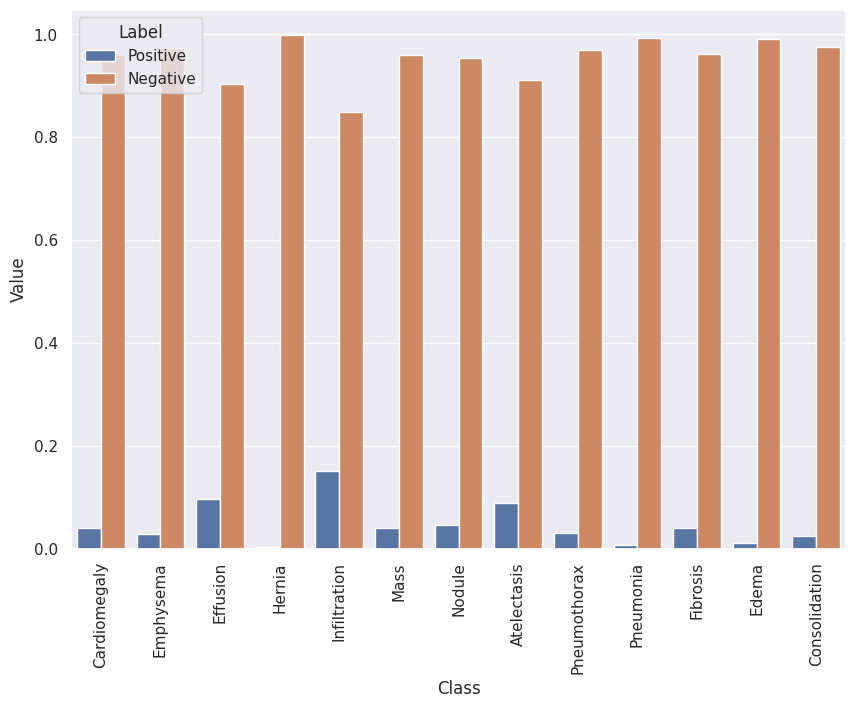

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Addressing Class Imbalance - Weighted Loss

<ipython-input-13-63b897b35505>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


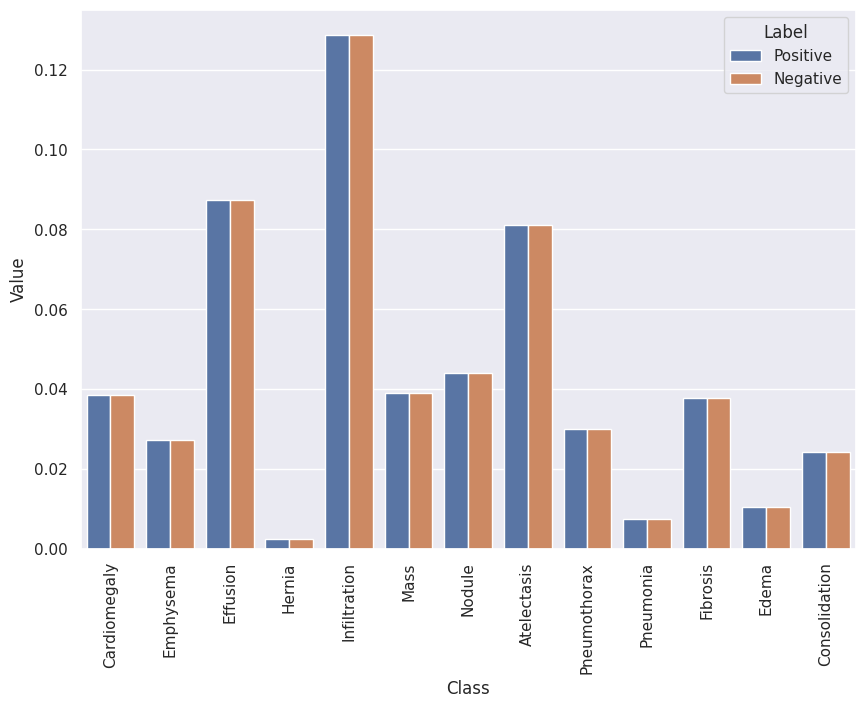

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

##varifying

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:
# def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
#     """
#     Return weighted loss function given negative weights and positive weights.

#     Args:
#       pos_weights (np.array): array of positive weights for each class, size (num_classes)
#       neg_weights (np.array): array of negative weights for each class, size (num_classes)

#     Returns:
#       weighted_loss (function): weighted loss function
#     """
#     def weighted_loss(y_true, y_pred):
#         """
#         Return weighted loss value.

#         Args:
#             y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
#             y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
#         Returns:
#             loss (Float): overall scalar loss summed across all classes
#         """
#         # initialize loss to zero
#         loss = 0.0

#         ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

#         for i in range(len(pos_weights)):
#             # for each class, add average weighted loss for that class
#             loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
#             - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) #complete this line
#         return loss

#         ### END CODE HERE ###
#     return weighted_loss
import tensorflow as tf
import keras.backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # Initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # Cast y_true to float32 to match the data type of y_pred
            y_true_cast = K.cast(y_true, dtype='float32')

            # For each class, add average weighted loss for that class
            loss += -pos_weights[i] * K.mean(y_true_cast[:, i] * K.log(y_pred[:, i] + epsilon)) \
                    -neg_weights[i] * K.mean((1 - y_true_cast[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
        return loss

    return weighted_loss


DenseNet121

In [ ]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():

    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    # create the base pre-trained model
    base_model = DenseNet121(weights='imagenet', include_top=False)
    print("Loaded DenseNet")
    # add a global spatial average pooling layer
    x = base_model.output
    x = tf.cast(x, dtype=tf.float32)
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    # model.load_weights("/content/drive/MyDrive/DATABASE/densenet121.pth")
    # print("Loaded Weights")
    return model

In [ ]:
model = load_C3M3_model()

Got loss weights
29084464/29084464 [==============================] - 0s 0us/step
Loaded DenseNet
Added layers
Compiled Model


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']      

Training

<ipython-input-18-ef40248ade6f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


100/100 [==============================] - 393s 3s/step - loss: 0.8415 - val_loss: 10.2251


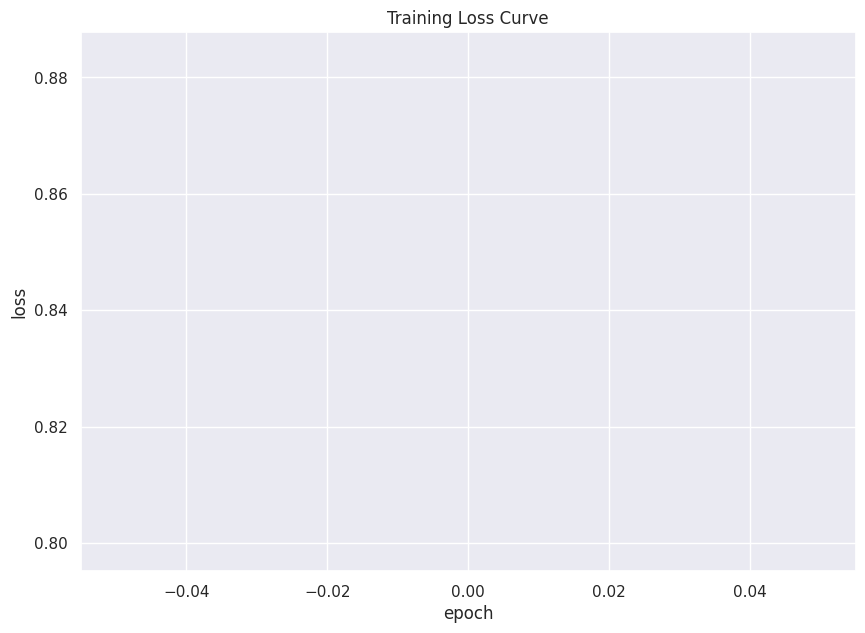

In [ ]:
history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              steps_per_epoch=100,
                              validation_steps=25,
                              epochs = 1)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

Prediction & Evaluation

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict

<ipython-input-19-30330970438d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


(428, 13)